In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
from IPython.display import Markdown, display
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import sys
sys.path.append(os.getcwd())
from roco2 import color, marker, plot, Kernel
from pylab import rcParams

from matplotlib.backends.backend_pdf import PdfPages
import subprocess

In [2]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (20,10)
pylab.rcParams['font.size'] = 20
pylab.rcParams['legend.fontsize'] = 20
def printmd(string):
    display(Markdown(string))

In [3]:
def old_kernel(n):
    return {
        0: Kernel.idle,
        1: Kernel.sine,
        2: Kernel.busywait,
        3: Kernel.memory,
        4: Kernel.compute,
        5: Kernel.mulpd,
        7: Kernel.matmul,
        8: Kernel.sqrt,
        9: Kernel.idle,
        10: Kernel.addpd,
        42: Kernel.firestarter
    }[n]


In [4]:
pp_dir = '.'
filenames = sorted(glob(pp_dir + os.path.sep + '*.tsv'))
filename_widget = widgets.Dropdown(options=filenames)
power_patterns = {
    'diana/watts': 'LMG reference measurement [W]',
    'diana/s.*': 'HAEC reference measurement [W]',
    'artemis/s.*': 'HAEC reference measurement [W]',
    'artemis/watts': 'LMG reference measurement [W]',
    'bogda/watts': 'LMG reference measurement [W]',
    'localhost/watts': 'LMG reference measurement [W]',
    'elab\..*\.power': "System AC Power [W]",
    'package.*': 'RAPL package + DRAM [W]',
    'x86_energy/.*/P': 'RAPL package + DRAM [W]',
    'x86_energy/P': 'RAPL package [W]',
    'AMD RAPL PCKG': 'RAPL Sum Package [W]',
    'AMD RAPL SINGLE_CORE': 'RAPL Sum Core [W]',
}
pattern_x_widget = widgets.Dropdown(options=tuple(power_patterns.keys()))
pattern_y_widget = widgets.Dropdown(options=tuple(power_patterns.keys()))

def update_filename(*args):
    tmp = pd.read_csv(filename_widget.value, sep='\t', quotechar="'")
    opt = tuple(filter(lambda pattern: len(tmp.filter(regex=pattern).columns) > 0, power_patterns.keys()))
    pattern_x_widget.options = opt
    pattern_y_widget.options = opt
    
filename_widget.observe(update_filename, 'value')
update_filename()

label_x = None
label_y = None
def read_phase_profile(filename, pattern_x, pattern_y):
    global experiments, label_x, label_y, experiment_basename
    experiments = pd.read_csv(filename, sep='\t', quotechar="'")
    experiment_basename = os.path.splitext(os.path.basename(filename))[0]
    printmd("### Number of experiments in {}: {}".format(experiment_basename, len(experiments)))
        
    label_x = power_patterns[pattern_x]
    label_y = power_patterns[pattern_y]
    power_x_columns = experiments.filter(regex=pattern_x)
    power_y_columns = experiments.filter(regex=pattern_y)
    printmd("### Using X-{} power metrics: {} [{}]" \
            .format(label_x, pattern_x, ', '.join(power_x_columns.columns.values)))
    printmd("### Using Y-{} power metrics: {} [{}]" \
            .format(label_y, pattern_y, ', '.join(power_y_columns.columns.values)))

    if experiments.experiment.max() == 42:
        experiments['kernel'] = experiments.experiment.apply(old_kernel)
    else:
        experiments['kernel'] = experiments.experiment.apply(Kernel)
        
    experiments['power_x'] = power_x_columns.sum(1)
    experiments['power_y'] = power_y_columns.sum(1)
    #experiments['power_x'] = (experiments['x86_energy/PACKAGE0/P'] + experiments['x86_energy/PACKAGE1/P'] + 0.25 * (experiments['x86_energy/DRAM0/P'] + experiments['x86_energy/DRAM1/P']) ) /1000
    experiments['frequency_mhz'] = (experiments['frequency'] / 1e6).astype(int)
    
    printmd('### Experiment duration: {:.1f} s'.format((experiments.end - experiments.begin).mean() / 1e12))
    
    printmd('### Kernels:')
    printmd('\n'.join([' * {}'.format(x) for x in experiments.kernel.unique()]))

    printmd('### Frequencies:')
    printmd('\n'.join([' * {}'.format(x) for x in experiments.frequency_mhz.unique()]))
    
    printmd('### Thread counts:')
    printmd('\n'.join([' * {}'.format(x) for x in experiments.thread_count.unique()]))
    
    # printmd('### DDCM settings:')
    # printmd('\n'.join([' * {}'.format(x) for x in sorted(experiments.ddcm.unique())]))
    
#
# i = interact(read_phase_profile, filename=filename_widget,
#              pattern_x=pattern_x_widget, pattern_y=pattern_y_widget)

In [35]:
from collections import defaultdict
def fit(dim):
    global model, model_name
    model = make_pipeline(PolynomialFeatures(dim), Ridge())
    model.fit(experiments.power_x.values.reshape(-1, 1), experiments.power_y)
    names = {
        1: 'linear',
        2: 'quadratic',
        3: 'cubic'
    }
    model_name = names[dim]

    for kernel, k_group in experiments.groupby('kernel'):
        plt.plot(k_group.power_x, k_group.power_y, color=kernel.color, marker=kernel.marker, ls='', label=kernel.name,
                 markerfacecolor="None", markeredgewidth=0.5, markersize=3)

    x_min, x_max = plt.gca().get_xlim()
    x_plot = np.linspace(x_min, x_max, 100)

    plt.plot(x_plot, model.predict(x_plot.reshape(-1,1)), ls=':', color='black', label='{} fit'.format(model_name))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plot.ideal(x_max, ls='-', color='gray', label='identity')

    plt.gca().set_xlim(xmin=0, xmax=x_max)
    plt.gca().set_ylim(ymin=0, ymax=x_max)
    # Err, lol, sorry
    plt.gca().set_xticks(plt.gca().get_yticks()[:-1])
    # plt.legend(loc='best', numpoints=1, fontsize=params['font.size'], ncol=2)
    #
    # plot.make_pdf(experiment_basename)
    #
    # plt.show()
    
# interact(fit, dim=(1,3))

In [36]:
def savefig(name, **kwargs):
    fn = "../../paper/fig/{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

### Number of experiments in conway: 5835

### Using X-System AC Power [W] power metrics: elab\..*\.power [elab.conway.power]

### Using Y-RAPL Sum Package [W] power metrics: AMD RAPL PCKG [AMD RAPL PCKG]

### Experiment duration: 6.0 s

### Kernels:

 * idle
 * busywait
 * compute
 * memory_read
 * memory_copy
 * memory_write
 * addpd
 * mulpd
 * sqrt
 * matmul

### Frequencies:

 * 2500
 * 2200
 * 1500

### Thread counts:

 * 128
 * 4
 * 8
 * 12
 * 16
 * 20
 * 24
 * 28
 * 32
 * 36
 * 40
 * 44
 * 48
 * 52
 * 56
 * 60
 * 64
 * 68
 * 72
 * 76
 * 80
 * 84
 * 88
 * 92
 * 96
 * 100
 * 104
 * 108
 * 112
 * 116
 * 120
 * 124

saving and cropping  ../../paper/fig/amd-epyc-7502-rapl-pkg.pdf


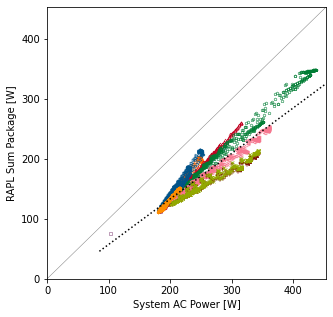

In [37]:
rcParams['font.size'] = 10
rcParams['legend.fontsize'] = rcParams['font.size']
rcParams['figure.figsize'] = (5,5)

read_phase_profile("./conway.tsv", "elab\..*\.power", "AMD RAPL PCKG")
fit(dim=1)
savefig("amd-epyc-7502-rapl-pkg")

### Number of experiments in conway: 5835

### Using X-RAPL Sum Package [W] power metrics: AMD RAPL PCKG [AMD RAPL PCKG]

### Using Y-RAPL Sum Core [W] power metrics: AMD RAPL SINGLE_CORE [AMD RAPL SINGLE_CORE]

### Experiment duration: 6.0 s

### Kernels:

 * idle
 * busywait
 * compute
 * memory_read
 * memory_copy
 * memory_write
 * addpd
 * mulpd
 * sqrt
 * matmul

### Frequencies:

 * 2500
 * 2200
 * 1500

### Thread counts:

 * 128
 * 4
 * 8
 * 12
 * 16
 * 20
 * 24
 * 28
 * 32
 * 36
 * 40
 * 44
 * 48
 * 52
 * 56
 * 60
 * 64
 * 68
 * 72
 * 76
 * 80
 * 84
 * 88
 * 92
 * 96
 * 100
 * 104
 * 108
 * 112
 * 116
 * 120
 * 124

saving and cropping  ../../paper/fig/amd-epyc-7502-rapl-core-pkg.pdf


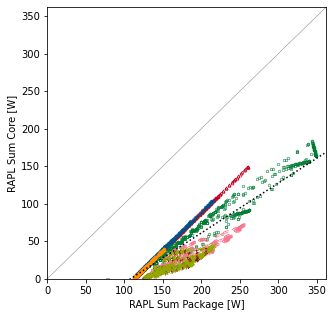

In [38]:
read_phase_profile("./conway.tsv", "AMD RAPL PCKG", "AMD RAPL SINGLE_CORE")
fit(dim=1)
savefig("amd-epyc-7502-rapl-core-pkg")

<ipython-input-36-a04905920409>:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "crop" which is no longer supported as of 3.3 and will become an error two minor releases later
  pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)


saving and cropping  ../../paper/fig/rapl-roco-legend.pdf


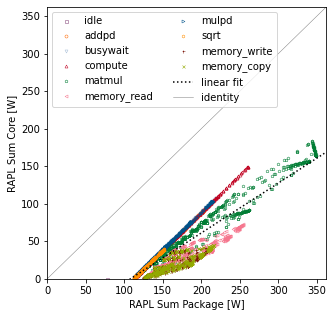

<Figure size 360x144 with 0 Axes>

In [39]:
fit(dim=1)
#rcParams['font.size']=10
plt.legend(loc='best', numpoints=1, fontsize=rcParams['font.size'], ncol=2)
ax = plt.gca()
figlegend = pylab.figure(figsize=(5,2))
pylab.figlegend(
    *ax.get_legend_handles_labels(),
    ncol=1,
    frameon=False,
)
savefig('rapl-roco-legend', crop=True)
